Project Title: Extracting Amazon's Nike Product and Marketing Insights through LDA Topic Modeling <br>
Date: 2024 March 19 <br>
Author: Tsai-Yun Li <br>
Course Lecturer: Chris J. Vargo and Scott Bradley <br>
Course: Unsupervised Text Classification for Marketing Analysis <br>
Organization: University of Colorado Boulder <br>
Datasets (provided in the course): Amazon Products Meta Data and Review Data <br>
GitHub Repository Link: https://github.com/TsaiYunLi/TextMA2_FinalProj_TsaiYunLi <br>
Google Colab Link: https://colab.research.google.com/drive/1LKMsk7qkk8W8g6ThpBFwhKY3eM-aQ7A2?usp=sharing

## Table of Contents

1. Problem Description
2. Data Description
3. Exploratory Data Analysis
4. Data Preparation
5. Topic Modeling using LDA
6. Data Clustering
7. Topic Summaries
8. Conclusion: Actionable Marketing and Product Insight
9. Limitations and Discussions
10. Refernces

## 1. Problem Description
This is an unsupervised text classification problem dealing with the meta and textual review data for Nike's products sold on Amazon. In this project I figured out possible topics of the reviews through LDA (Latent Dirichlet Allocation) topic modeling, an unsupervised, generative statistical model, and then automatically classify the reviews into different topics by performing data clustering. With the results from these two steps, each topic was consolidated into a short summary of its content, including the name of representing products mapped from their ASINs (Amazon Standard Identification Numbers
) when possible. This enables me to extract actionable marketing and product insight of the Nike products sold on Amazon, in an attempt to help examine or improve Nike's marketing strategies on Amazon.

## 2. Data Description
The data used in this project include: <br>
1. a textual meta data of the Nike products sold on Amazon which consist each product's asin, related asins (other products bought or viewed together), title, price, sales rank, image URL,and the categories it falls into.
2. and a textual review data of each product, identified by its ASIN.

These two datasets are both provided as gzip files in the lecture, selected by the lecturer from the "Amazon Product Data”database compiled by Prof. Julian McAuley at UC-San Diego.

## 3. Exploratory Data Analysis

In [ ]:
import gzip
import itertools
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## getting all the ASINS of Nike products in Amazon reviews

asins = [] #ASINS = Amazon Standard Identification Numbers

with gzip.open("drive/MyDrive/meta_Clothing_Shoes_and_Jewelry.jsonl.gz") as products:
    for product in products:
        data = json.loads(product) # parsing the JSON content from each line into a Python dictionary
        categories = [c.lower() for c in
                      list(itertools.chain(*data.get("categories", [])))]
        if "nike" in categories: # case-insensitive
            asins.append(data["asin"])

print(f'len(asins)={len(asins)}')

len(asins)=8327


In [ ]:
asins[:5]

['B0000V9K32', 'B0000V9K3W', 'B0000V9K46', 'B0000V9KNM', 'B0000V9KRI']

In [ ]:
## using the Nike products' ASINS in Amazon reviews to get the review texts

all_texts = []
with gzip.open("drive/MyDrive/reviews_Clothing_Shoes_and_Jewelry_5.json.gz") as reviews:
    for review in reviews:
        data = json.loads(review)
        if data["asin"] in asins:
            # creating a dictionary with keys 'asin' and 'reviewText'
            entry = {"asin": data["asin"], "reviewText": data["reviewText"]}
            all_texts.append(entry)
print(f'len(all_texts)={len(all_texts)}')

len(all_texts)=399


In [ ]:
for entry in all_texts[:5]: #the first five reviews of the all_texts list
    print(f"ASIN: {entry['asin']}, Review: {entry['reviewText'][:140]}\n")
    #asin, first 140 characters of each review, which fits on this screen

ASIN: B0007RADZ8, Review: bought these for supportive shoes after our daughter had ankle surgery. Great fit, great price, seem to be holding up well!

ASIN: B0007RADZ8, Review: I was a little hesitant about buying sneakers online, fearing I might end up with some fakes. But nah these are legit, good build, good qual

ASIN: B0007RADZ8, Review: I have a lot of pairs of running shoes, and these are a nice addition to my collection. To me, they feel like a more casual shoe, than a pur

ASIN: B0007RADZ8, Review: My husband said they are very comfortable and easy to walk in, which he does a lot of. They also look really nice on him. Great buy!

ASIN: B0007RADZ8, Review: Very nice shoes...my son loved the color and comfort and the lite weight. Would recommend this shoe to everyone  that's looking for a nice r



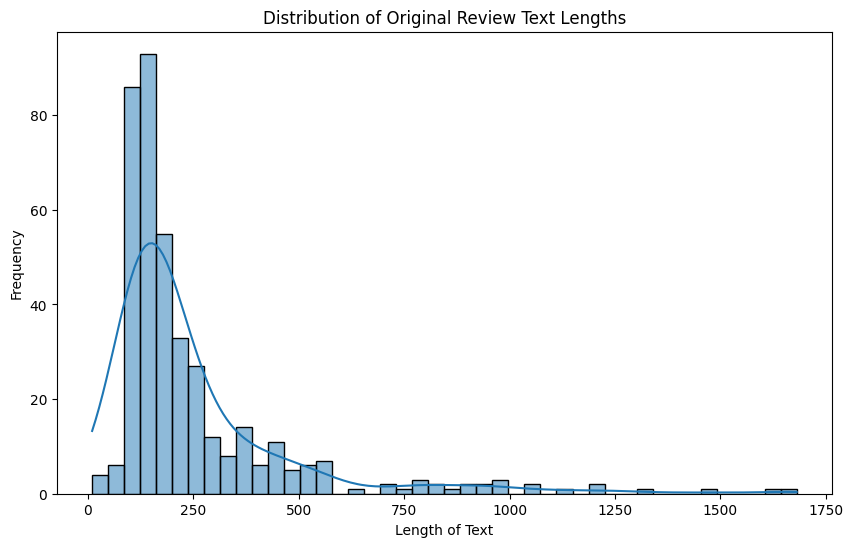

In [ ]:
# visualizing the length distribution of the Nike product's Amazon review texts
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

text_lengths = [len(entry['reviewText']) for entry in all_texts]
df = pd.DataFrame(text_lengths, columns=['Length'])

plt.figure(figsize=(10, 6))
sns.histplot(df['Length'], kde=True)
plt.title('Distribution of Original Review Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

##### Section Summary:
1. There are 8327 Nike products in the dataset.
2. The asins variable stores Nike products' ASINs in a list.
3. The all_text variable stores the review texts of the identified Nike products.
4. I did not remove outliers in terms of review text length since they do not seem to skew the result of the following topic modeling and analysis.


## 4. Data Preparation

In [ ]:
import re
%pip install nltk
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
all_texts_preprocessed = all_texts #made a copy of all_texts and modify on the copy to keep the original data intact

In [ ]:
for i, entry in enumerate(all_texts_preprocessed):
    text = entry['reviewText']
    text = text.lower() #lowercasing
    text = re.sub(r'[^\w\s]|_|\\', ' ', text) #replacing punctuation with a space
    text = re.sub(r'\s+', ' ', text).strip() #removing extra spaces, incl. tabs
    text = re.sub(r'\d+', '', text) # removing numbers
    all_texts_preprocessed[i]['reviewText'] = text #assigning the processed text back to the list at the same position

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stop_words(text):
    words = word_tokenize(text)
    no_stop_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(no_stop_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
nltk.download('words')
english_words = set(nltk.corpus.words.words())
def remove_non_english_words(text):
    words = word_tokenize(text)
    english_words_only = [word for word in words if word.lower() in english_words]
    return ' '.join(english_words_only)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def tokenization_then_lemmatization(text):
    tokenized_words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(tokenized_word) for tokenized_word in tokenized_words]
    return ' '.join(lemmatized_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
for i, entry in enumerate(all_texts_preprocessed):
    text = entry['reviewText']
    text = remove_stop_words(text) #removing stop words
    text = remove_non_english_words(text)  #removing non-English words
    text = tokenization_then_lemmatization(text) #tokenizing #lemmatizing
    all_texts_preprocessed[i]['reviewText'] = text #assigning the processed text back to the list at the same position

In [ ]:
for entry in all_texts[:5]: #the first five reviews of the all_texts list
    print(f"ASIN: {entry['asin']}, Review: {entry['reviewText'][:140]}\n")
    #asin, first 140 characters of each review, which fits on this screen

ASIN: B0007RADZ8, Review: bought supportive daughter ankle surgery great fit great price seem holding well

ASIN: B0007RADZ8, Review: little hesitant might end legit good build good quality color look great together light recommend stylish great running

ASIN: B0007RADZ8, Review: lot running nice addition collection feel like casual shoe pure running shoe wear gym going loft use run shoe well great size may run fracti

ASIN: B0007RADZ8, Review: husband said comfortable easy walk lot also look really nice great buy

ASIN: B0007RADZ8, Review: nice son color comfort lite weight would recommend shoe everyone looking nice running shoe



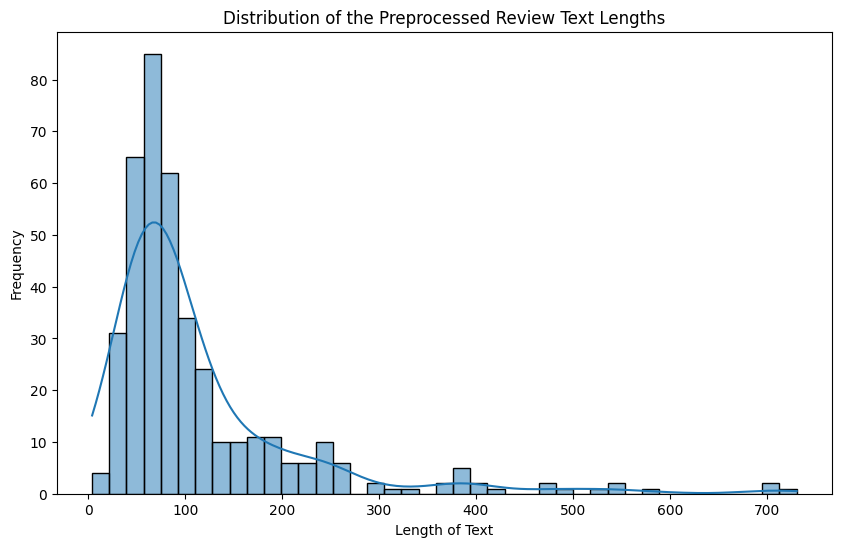

In [ ]:
# visualizing the length distribution of the Nike product's Amazon review texts after preprocessings

text_lengths = [len(entry['reviewText']) for entry in all_texts_preprocessed] #
df = pd.DataFrame(text_lengths, columns=['Length'])

plt.figure(figsize=(10, 6))
sns.histplot(df['Length'], kde=True)
plt.title('Distribution of the Preprocessed Review Text Lengths') #
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

##### Section Summary:
1. The review texts have underwent the following preprocessing procedures: (1) lowercasing, (2) removing punctuations, extra spaces, and numbers, (3) removing stopwords, (4) removing non-English words, (5) tokenization, and (6) lemmatization.
2. The all_texts_preprocessed variable stores a list of dictionary entries of asin and its corresponing review texts.
3. The all_texts list created in the last section is left intact.

## 5. Topic Modeling using LDA

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel

texts = [entry['reviewText'].split() for entry in all_texts_preprocessed] #sperate by space
asins = [entry['asin'] for entry in all_texts_preprocessed]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_params = {
    'num_topics': 50, #value inspired by the lecturer's work
    'eta': 0.01,
    'iterations': 1000, #increased after seeing the too-few-updates warning
    'random_state': 20240315,
    'alpha': 1/50 #1/num_topics
}

lda_model = LdaModel(corpus=corpus, id2word=dictionary, passes=30, **lda_params)
#number of passes increased after seeing the too-few-updates warning

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.029*"size" + 0.029*"really" + 0.022*"would" + 0.022*"wear" + 0.022*"well" + 0.015*"next" + 0.015*"shoe" + 0.015*"like" + 0.015*"unusual" + 0.015*"foot"
Topic: 1 
Words: 0.029*"time" + 0.024*"buy" + 0.019*"big" + 0.019*"men" + 0.019*"little" + 0.015*"sure" + 0.015*"love" + 0.014*"washed" + 0.014*"top" + 0.014*"bit"
Topic: 2 
Words: 0.022*"fit" + 0.022*"like" + 0.022*"ordered" + 0.017*"shoe" + 0.017*"good" + 0.017*"running" + 0.017*"work" + 0.017*"feel" + 0.017*"size" + 0.017*"know"
Topic: 3 
Words: 0.055*"pair" + 0.053*"comfortable" + 0.038*"great" + 0.038*"wear" + 0.038*"walking" + 0.038*"never" + 0.030*"last" + 0.025*"lot" + 0.025*"first" + 0.025*"buy"
Topic: 4 
Words: 0.081*"running" + 0.030*"husband" + 0.027*"lightweight" + 0.023*"dart" + 0.015*"heel" + 0.015*"mesh" + 0.015*"breathable" + 0.015*"cushioned" + 0.015*"outsole" + 0.015*"greater"
Topic: 5 
Words: 0.045*"comfortable" + 0.026*"good" + 0.018*"well" + 0.018*"give" + 0.018*"like" + 0.018*"go" + 0.018*"paddi

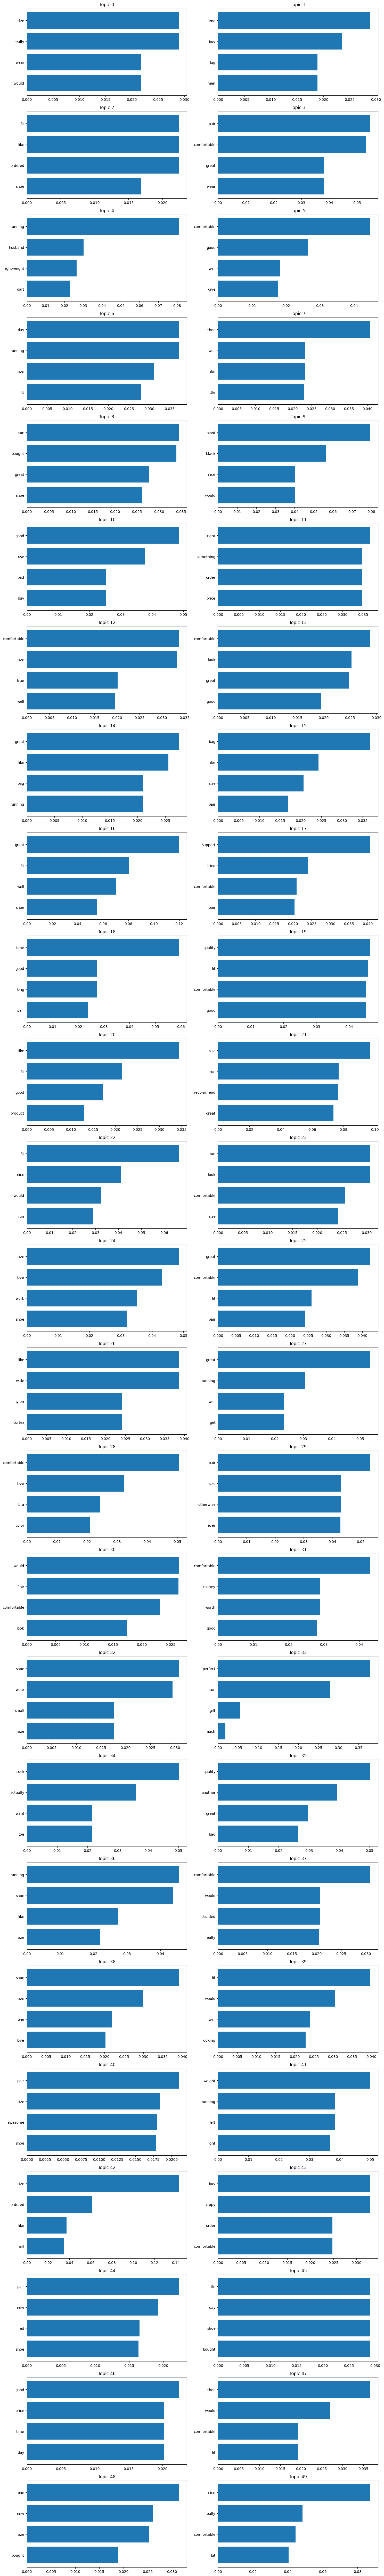

In [ ]:
import matplotlib.pyplot as plt #pyLAvis not working so I use this library instead

num_words = 4 #the top 4 words in each topic #number inspired by the lecturer's work
topics = lda_model.show_topics(num_topics=lda_params['num_topics'], num_words=num_words, formatted=False)
fig, axes = plt.subplots(ncols=2, nrows=lda_params['num_topics'] // 2, figsize=(15, 2 * lda_params['num_topics']))
axes = axes.flatten()
for idx, topic in topics:
    words, weights = zip(*topic)
    axes[idx].barh(words, weights)
    axes[idx].set_title(f'Topic {idx}')
    axes[idx].invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Data Clustering

In [ ]:
import pandas as pd

# getting the dominant topic for each document
dominant_topics = []
for i, row in enumerate(lda_model[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:
            dominant_topics.append((i, topic_num, prop_topic))

In [ ]:
# clustering data by their dominant topics
document_df = pd.DataFrame(dominant_topics, columns=['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib'])
document_df['ASIN'] = asins
document_df['Review'] = texts

In [ ]:
# observing the head of the document_df dataframe
document_df.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,ASIN,Review
0,0,16,0.570188,B0007RADZ8,"[bought, supportive, daughter, ankle, surgery,..."
1,1,21,0.948420,B0007RADZ8,"[little, hesitant, might, end, legit, good, bu..."
2,2,7,0.901713,B0007RADZ8,"[lot, running, nice, addition, collection, fee..."
3,3,13,0.491811,B0007RADZ8,"[husband, said, comfortable, easy, walk, lot, ..."
4,4,26,0.550778,B0007RADZ8,"[nice, son, color, comfort, lite, weight, woul..."


In [ ]:
# observing the tail of the document_df dataframe
document_df.tail()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,ASIN,Review
394,394,23,0.697710,B00C8P9K2E,"[ordered, half, size, due, rapidly, growing, r..."
395,395,0,0.020000,B00C8P9K2E,[dope]
396,396,8,0.877498,B00C8P9K2E,"[son, happy, new, x, wearing, great, quality]"
397,397,13,0.942352,B00C8P9K2E,"[would, expect, best, comfortable, good, price..."
398,398,47,0.966206,B00C8P9K2E,"[bought, son, birthday, seen, want, say, coupl..."


In [ ]:
# sampling up to 12 reviews from each topic
for topic_num in sorted(document_df['Dominant_Topic'].unique()):
    print(f"Topic {topic_num} Reviews and ASINs:")
    topic_reviews = document_df[document_df['Dominant_Topic'] == topic_num]
    num_samples = min(12, len(topic_reviews))
    sample_reviews = topic_reviews.sample(n=num_samples, random_state=20240315)
    for index, row in sample_reviews.iterrows():
        print(f"ASIN: {row['ASIN']} - Review: {' '.join(row['Review'])[:200]}")
    print('-' * 75)

Topic 0 Reviews and ASINs:
ASIN: B004YI0X6A - Review: stuff done thought plus looking something hold pair gym clothes though way big
ASIN: B004CW07AU - Review: husband picky promptly fit exactly hoped husband lot soft give little cushioned effect surface material bit unusual feel almost foot cool moist top loop bottom glued unusual well made
ASIN: B003NYUSPM - Review: exactly pictured son may buy soon
ASIN: B005OCL7XI - Review: price beat quality durability fit grandson really tough one well
ASIN: B00C8P9K2E - Review: dope
ASIN: B003QL2SQO - Review: know stuff supposed fitted downright tight wear shoe bought large size struggle get foot somewhat compressed like wear would like said definitely keep drier run mill cotton point
ASIN: B001Q8LW8O - Review: hubby regularly wear well sizing spot would order
ASIN: B007N72C9U - Review: th grade son size shoe based thought would right size really really snug probably small really care deal long next time however buy next size might soon may end 

In [ ]:
import pandas as pd
import json
import gzip
import itertools

# mapping each ASIN to its correponding product title
asin_to_title = {}
with gzip.open("drive/MyDrive/meta_Clothing_Shoes_and_Jewelry.jsonl.gz") as products:
    for product in products:
        data = json.loads(product)
        categories = [c.lower() for c in itertools.chain(*data.get("categories", []))]
        if "nike" in categories:
            asin_to_title[data["asin"]] = data.get("title", "No title available")

# getting the top 3 most common asins per topic
asin_counts = document_df.groupby(['Dominant_Topic', 'ASIN']).size().reset_index(name='counts')
sorted_asins = asin_counts.sort_values(['Dominant_Topic', 'counts'], ascending=[True, False])
top_asins_per_topic = sorted_asins.groupby('Dominant_Topic').head(3)
for topic, group in top_asins_per_topic.groupby('Dominant_Topic'):
    print(f"Topic {topic} most common products:")
    for _, row in group.iterrows():
        title = asin_to_title.get(row['ASIN'], "Title not found")
        print(f"ASIN: {row['ASIN']} - Title: {title} - Counts: {row['counts']}")
    print('-' * 75)

Topic 0 most common products:
ASIN: B001Q8LW8O - Title: Nike Men's NIKE SWEET CLASSIC LEATHER CASUAL SHOES - Counts: 1
ASIN: B003NYUSPM - Title: Nike SX4206 Dri-Fit Half-Cushion Crew Socks - 3 pack - Counts: 1
ASIN: B003QL2SQO - Title: Nike Unisex 3Pk Dri Fit Half Cush Qtr - Counts: 1
---------------------------------------------------------------------------
Topic 1 most common products:
ASIN: B000V4YZ1K - Title: Nike Men's Benassi Swoosh Slide Sandal - Counts: 1
ASIN: B0013UXIAK - Title: Nike The Overplay VII Men's Basketball Shoe - Counts: 1
ASIN: B001718DSM - Title: Nike Womens Celso Girl Thong - Counts: 1
---------------------------------------------------------------------------
Topic 2 most common products:
ASIN: B000V4YZ1K - Title: Nike Men's Benassi Swoosh Slide Sandal - Counts: 1
ASIN: B001LDDR0K - Title: Nike Men's Comfort Slide 2 Sandal - Counts: 1
ASIN: B002FKHOOS - Title: Nike Men's Flex Run 2013 Running Shoe - Counts: 1
---------------------------------------------------

## 7. Topic Summaries
Topic 0 - Nike shoes and socks fit well. <br>
Topic 1 - Customers would likely buy Nike sandals again. <br>
Topic 2 - Nike men’s sandals fit well, are well-liked, and commonly ordered. <br>
Topic 3 - Nike sandals are comfortable. <br>
Topic 4 - Customers bought Nike sneaker, running shoes, or pro bra for running. They praised these products’ lightweight. <br>
Topic 5 - Customers find Nike sandals and basketball shoes to be comfortable, with some noting the good padding and recommendation for daily wear. <br>
Topic 6 - Nike running shoes are appreciated for their fit and comfort, making them suitable for all-day wear and providing a light, air-cushioned experience. < br>
Topic 7 - Nike sandals and running shoes, especially Men's Benassi JDI Slide Sandal, Free 5.0+ Men’s Running Shoes, and Women's Dart 10 Running Shoes, are well-received for their comfortable fit and stylish design, suitable for both athletic and casual wear. <br>
Topic 8 - Nike running shoes, especially Dart 9 Men's Running Shoes, are often bought and thought to be a great gift for sons. <br>
Topic 9 - Nike men’s running shoes, basketball shoes, and moisture management socks are favored for their comfort and quality of thickness. The most commonly bought ones are in black or white. <br>
Topic 10 - Nike Men’s and Women’s Benassi Sandals are both praised for their comfort and fit. <br>
Topic 11 - Customers value the good price and order accuracy for their Nike purchases, highlighting the importance of value and order fulfillment. <br>
Topic 12 - Customers appreciate the comfort and true-to-size fit of Nike sneakers and running shoes. <br>
Topic 13 - Customers like the look and comfort of Nike shoes and socks. Some mentioned them as good choice of gifts for sons. <br>
Topic 14 - Nike's products, particularly their running gear and socks, are recognized for their great quality and functionality, enhancing athletic performance. <br>
Topic 15 - Nike's bags, especially their Brasilia 5 Small Duffel Grip, are noted for their perfect size, good quality, and nice look. <br>
Topic 16 - Nike’s professional sports footwear, especially their Air Monarch IV Men's Cross Training Shoes, Overplay VII Men's Basketball Shoes, and Women's Dart 9 Running Shoes, are appreciated for their good fit, comfort, and stylish look. Some customers bought them as gifts for their daughters. <br>
Topic 17 - Nike's supportive footwear is appreciated for its comfortable fit and arch support. <br>
Topic 18 - Nike sports shoes, especially Nike Zoom Vomero+ 7 Womens Size 6 Gray Mesh Running Shoes UK 3.5 EU 36.5, are praised for their durable and long-lasting quality, favored for gym use and prolonged wear. <br>
Topic 19 - Nike shoes’ and socks’ high-quality, comfortable fit, and good design are praised. <br>
Topic 20 - Nike sandals are liked for their good fit and material quality. Customers especially praised the mesh material of these sandals. <br>
Topic 21 - Nike running shoes are praised for their true-to-size fit and comfort. Customers are willing to recommend them to others. <br>
Topic 22 - Customers found Nike’s sandals fit well and emphasized their softness. <br>
Topic 23 - Customers liked the look and comfort of Nike sandals and running shoes, especially the cushioned bottom and their quality of lightness. <br>
Topic 24 - Nike women’s running shoes and slide sandals, especially Free 5.0 Women’s Running Shoes, Women's Revolution 2 Running Shoes, and Women's Comfort Slide Sandals, are considered comfortable. Customers pointed out that the sandals are suitable for walking. <br>
Topic 25 - Nike sandals and socks are liked for their comfort and fit, especially Men's Benassi Swoosh Slide Sandal . <br>
Topic 26 - Customers liked the nylon and leather material of Nike running shoes and sneaker. <br>
Topic 27 - Nike running shoes, sports bras, and socks are praised for their good support for running. <br>
Topic 28 – Nike sports bras and sneakers are favored for their color options and overall comfort, enhancing the workout experience. <br>
Topic 29 - Customers praised the good fit of Nike men’s professional sports shoes. Some bought them for their husbands. <br>
Topic 30 - Nike slide sandals and casual sneakers are praised for their comfort and style, suitable for both athletic and casual outings. < br>
Topic 31 - Nike shoes and sandals are considered worth the money; customers emphasized their good price for their quality of comfort, especially Women's Comfort Thong Sandal. <br>
Topic 32 - Nike's footwear, including sandals and running shoes, especially Women's Comfort Thong Sandal, is favored for its lightweight design and comfortable fit, catering to a range of activities. <br>
Topic 33 - Nike Men's Downshifter 5 Running Shoes are considered perfect gifts for sons. <br>
Topic 34 - Nike socks and duffle bags, especially those for men, are praised for their quality and comfort. <br>
Topic 35 - Customers appreciated the comfort, quality, and good support of Nike’s sneakers, running shoes, and bras. Some said that they bought these as birthday gifts. <br>
Topic 36 - Nike men’s running shoes, Men's Downshifter 5 Running Shoes, Men’s Dart 10 Running Shoes, and Men's Revolution 2 Running Shoes, are liked for their good fit. <br>
Topic 37 - Nike women’s running shoes are praised for their comfort, fit, and look. <br>
Topic 38 - Nike’s casual footwear for men and women, including sandals and sneakers, are considered fashionable and comfortable. <br>
Topic 39 - Nike men’s and women’s slide sandals are loved for their good fit and nice look. <br>
Topic 40 - Customers commented about the size of Nike socks and running shoes. Some complained about their fit. <br>
Topic 41 - Nike’s footwear is appreciated for their light weight. <br>
Topic 42 - Some customers liked the Nike footwear they bought, but some complained about their tightness and recommend buying a bigger size for a better fit. <br>
Topic 43 - Customers experienced an overall happy purchase experience for Nike footwear and sports accessories. Some liked them in red. <br>
Topic 44 - Nike Air Monarch IV Men's Cross Training Shoes and Nike Women's Comfort Thong Sandal are praised for their look and comfort. Some liked them in red. <br>
Topic 45 - Nike sandals are liked for their comfort. Some mentioned the color purple. <br>
Topic 46 - Nike socks and casual sneakers are appreciated for their good price, quality, and comfort. <br>
Topic 47 - Nike’s footwear is considered comfortable. Customers would like to recommend them to others. <br>
Topic 48 - Nike men’s running shoes and basketball shoes are liked for their good support and balance. <br>
Topic 49 - Nike’s sandals are praised for their comfort and quality. <br>


### 8. Conclusion: Actionable Marketing and Product Insight

Through LDA topic modeling, data clustering, and a qualitative topic analysis of the review texts for Nike products sold on Amazon, we can tell that the reviews focus on approximately 10 major products: Nike basketball shoes, running shoes, training shoes, causal sneakers, slide sandals, thong sandals, socks, sports bra, duffle bags, and gymsacks. Customers particularly valued the comfort, quality, fit, and support provided by Nike products, with an emphasis on their sports footwear. Many also praised the brand's competitive pricing and accurate order fulfillment. Additionally, the fashionable design and appearance of their sandals and casual sneakers received notable appreciation. Some customers mentioned that they bought Nike products as gifts for their family members. Nevertheless, there are some negative reviews about some Nike footwear being too tight. <br>

Therefore, it is important for Nike to maintain the comfort and good quality but improve the fit of their sports footwear. A slight increase in price for product improvement would likely be accepted by the customers. As for casual footwear, Nike should focus on style and design. <br>

Since some customers bought Nike products as gifts for their family, Nike could focus their advertisement on school-starting days, graduate seasons, Christmas, and other special days. Tracking customers' and their family members' bithday and recommend Nike products to them near their birthdays would also likely be effective. <br>

The most commonly reviewed and praised Nike products across the top 3 most common products for each topic are Nike Men's Benassi Swoosh Slide Sandal (counts 12), Nike Men's Downshifter 5 Running Shoes (counts 9), Nike Men's Revolution 2 Running Shoes (counts 7), Nike The Overplay VII Men's Basketball Shoe (counts 6), and Nike Women's Comfort Thong Sandal (counts 6). Thus, Nike could keep selling these products and make them the classics. In addition, modified edition of these products would likely guarantee good sale.


## 9. Limitations and Discussions
There are a few limitations in this project. First of all, the number and content of the topics might not perfectly suit the review data. I've tried a much smaller and much larger number of topic during the LDA topic modeling process. They resulted in topics that are seemingly too broad or too narrow. However, this judgement was made solely subjectively through reading the topic words and sampled reviews. A quantitative approach would definitely be a good compliment to my qualitative view. However, quantitative approaches for checking the topics are not taught in class. If I were to improve this project, I would take time to do some research in this area and further optimize the hyperparameters for LDA topic modeling. <br>

Another major limitation is that I do not come from a marketing background. The product and marketing insight for the Nike product sold on Amazon derived from my analysis is merely from a lay man's perspective. I believe that a marketing expert might not totally agree with my suggestions for Nike's marketing strategy and would like to add a few more. In other words, the product and marketing insight I've extracted is solely based on the qualitative outputs of this project, without any professional knowledge of marketing. Therefore, one cannot take my suggestions for Nike too seriously. This is merely a programming exercise. <br>

There are two minor concerns of the preprocessed review data. I have removed non-English words in the review texts to avoid inaccuracy in the topic modeling process. Nevertheless, I happen to see a possible inconsistency in a sampled review for topic 26: "ASIN: B0058XRDWM - Review: excelente la de tal se lo para". The other issue is that some of the review texts appear to include non-lemma like in "
ASIN: B003NYUSPM - Review: er got g" in topic 23. Why and how do this failure of non-English word removal and problematic lemmatization occur? These are the two technical issues I could not solve in this project. <br>

Please let me know if you have any solution or suggestion for the limitations in this project! <br>

Please do not copy my text or code without proper citation, thank you!

## 10. References
1. Code built on all the labs provided in the course
2. Data Source: provided in the course as "meta_Clothing_Shoes_and_Jewelry.jsonl.gz" and "reviews_Clothing_Shoes_and_Jewelry.json.gz".
3. Shashank Kapadia. (2019). Topic Modeling in Python: Latent Dirichlet Allocation (LDA). Medium. https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0.
4. Zijing Zhu. (2021). The Ultimate Guide to Clustering Algorithms and Topic Modeling. Medium. https://towardsdatascience.com/wthe-ultimate-guide-to-clustering-algorithms-and-topic-modeling-4f7757c115.
5. Sentdex. (2015). NLTK with Python 3 for Natural Language Processing. Youtube. https://www.youtube.com/playlist?list=PLQVvvaa0QuDf2JswnfiGkliBInZnIC4HL
6. Gensim. (2022). Topic Modeling for Humans. GENSIM. https://radimrehurek.com/gensim/
